# Kuramoto-Sivashinsky Equation Energy-Preserving Operator Inference

In [1]:
using FFTW
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using ProgressMeter
using SparseArrays
using Statistics

include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn
;

In [2]:
# Settings for the KS equation
KSE = KS(
    [0.0, 100.0], [0.0, 500.0], [0.5, 1.4],
    256, 0.05, 10, "ep"
)
;

In [3]:
# WARNING: DO YOU WANT TO SAVE DATA?
save_data = true

# Create file name to save data
filename = "data/kse_epopinf_01.jld2"
;

In [4]:
# Minimum and maximum dimensions
rmin = 1
rmax = 10

KSE_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
KSE_vars = LnL.vars(
    N=1,
)
KSE_data = LnL.data(
    Δt=0.05,
    DS=10,
)
KSE_optim = LnL.opt_settings(
    verbose=false,
    initial_guess=false,
    max_iter=1000,
    reproject=false,
    SIGE=false,
)

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
)

# Downsampling rate
DS = KSE_data.DS

# Down-sampled dimension of the time data
Tdim_ds = size(1:DS:KSE.Tdim, 1)  # downsampled time dimension

# Number of random test inputs
num_test_ic = 50

;


## Generate Training Data

We use the initial condition of 

$$
\begin{gather*}
    u(x,0) = a\cos\left( \frac{2\pi x}{L} \right) + b\cos\left( \frac{4\pi x}{L} \right) + c
\end{gather*}
$$

where $a, b, c$ are parameters that vary. For the training of the energy-preserving model we use a set of 9 initial conditions with the parameter values of 

- $a = [0.5, 1.0, 1.5]$
- $b = [-0.2,0,0.2]$
- $c = [-0.5,0,0.5]$

In [5]:
# Parameters of the initial condition
ic_a = [0.5, 1.0, 1.5]
ic_b = [-0.2, 0, 0.2]
ic_c = [-0.5, 0, 0.5]

ic_a_out = [-1.0, 3.0]
ic_b_out = [-1.0, 1.0]
ic_c_out = [-1.0, 1.0]
num_ic_params = Int(length(ic_a) * length(ic_b) * length(ic_c))

# Parameterized function for the initial condition
u0 = (a,b,c) -> a * cos.((2*π*KSE.x)/KSE.Xdim) .+ b * cos.((4*π*KSE.x)/KSE.Xdim) .+ c  # initial condition
;  

In [13]:
# Store values
Xtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training state data 10x1
Rtr = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # training derivative data 10x1
Xtr_all = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_ic_params)  # all training data 10x27
IC_train = Vector{Vector{Float64}}(undef, num_ic_params)  # all initial conditions 
Vrmax = Vector{Matrix{Float64}}(undef, KSE.Pdim)  # POD basis 10x1
op_fom_tr = Vector{LnL.operators}(undef, KSE.Pdim)  # FOM operators 10x1

@info "Generate the FOM system matrices and training data."
@showprogress for i in 1:length(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A, F = KSE.model_FD(KSE, μ)
    op_fom_tr[i] = LnL.operators(A=A, F=F)

    # Store the training data 
    Xall = Vector{Matrix{Float64}}(undef, num_ic_params)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ic_params)
    
    # Generate the data for all combinations of the initial condition parameters
    ct = 1  # set/reset counter
    for a in ic_a, b in ic_b, c in ic_c
        if i == 1
            IC_train[ct] = u0(a, b, c)
        end

        states = KSE.integrate_FD(A, F, KSE.t, IC_train[ct])
        Xtr_all[i,ct] = states
        
        tmp = states[:, 2:end]
        Xall[ct] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / KSE.Δt
        Xdotall[ct] = tmp[:, 1:DS:end]  # downsample data

        ct += 1  # increment counter
    end
    # Combine all initial condition data to form on big training data matrix
    Xtr[i] = reduce(hcat, Xall) 
    Rtr[i] = reduce(hcat, Xdotall)
    
    # Compute the POD basis from the training data
    tmp = svd(Xtr[i])
    Vrmax[i] = tmp.U[:, 1:rmax]
end

if save_data
    Data = Dict("Xtr" => Xtr, "Rtr" => Rtr, "Vrmax" => Vrmax, 
            "op_fom_tr" => op_fom_tr, 
            "Xtr_all" => Xtr_all, "IC_train" => IC_train)
    @save filename Data
end

┌ Info: Generate the FOM system matrices and training data.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:9


Progress:  20%|█████████                                |  ETA: 0:18:09

Progress:  30%|█████████████                            |  ETA: 0:19:15

Progress:  40%|█████████████████                        |  ETA: 0:18:34

Progress:  50%|█████████████████████                    |  ETA: 0:17:49

Progress:  60%|█████████████████████████                |  ETA: 0:16:14

Progress:  70%|█████████████████████████████            |  ETA: 0:13:58

Progress:  80%|█████████████████████████████████        |  ETA: 0:09:53

Progress:  90%|█████████████████████████████████████    |  ETA: 0:05:19

Progress: 100%|█████████████████████████████████████████| Time: 0:58:18


## Generate Test Data (Inside Training Region)

Generate random initial condition parameters from the training region for $\mu \in M$.


In [ ]:
# Store values
Xtest_in = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_in = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters within the training region."

# Generate 10 random initial condition parameters
ic_a_rand_in = (maximum(ic_a) - minimum(ic_a)) .* rand(num_test_ic) .+ minimum(ic_a)
ic_b_rand_in = (maximum(ic_b) - minimum(ic_b)) .* rand(num_test_ic) .+ minimum(ic_b)
ic_c_rand_in = (maximum(ic_c) - minimum(ic_c)) .* rand(num_test_ic) .+ minimum(ic_c)

@showprogress for i in 1:length(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic  
        a = ic_a_rand_in[j]
        b = ic_b_rand_in[j]
        c = ic_c_rand_in[j]

        if i == 1
            IC_test_in[j] = u0(a, b, c)
        end
        Xtest_in[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_in[j])
    end
end

if save_data
    Data["Xtest_in"] = Xtest_in
    Data["IC_test_in"] = IC_test_in
    @save filename Data
end

## Generate Test Data (Outside Training Region)

Generate random initial condition parameters outside of the training region for $\mu \in M$.

In [ ]:
# Store values
Xtest_out = Matrix{Matrix{Float64}}(undef, KSE.Pdim, num_test_ic)  # all training data 
IC_test_out = Vector{Vector{Float64}}(undef, num_test_ic)  # all initial conditions

@info "Generate test data for parameters outside the training region."

# Generate 10 random initial condition parameters outside the training region
ϵ=1e-2
half_num_test_ic = Int(num_test_ic/2)
ic_a_rand_out = ((minimum(ic_a) - ϵ) - ic_a_out[1]) .* rand(half_num_test_ic) .+ ic_a_out[1]
append!(ic_a_rand_out, (ic_a_out[2] - (maximum(ic_a) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_a) + ϵ))
ic_b_rand_out = ((minimum(ic_b) - ϵ) - ic_b_out[1]) .* rand(half_num_test_ic) .+ ic_b_out[1]
append!(ic_b_rand_out, (ic_b_out[2] - (maximum(ic_b) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_b) + ϵ))
ic_c_rand_out = ((minimum(ic_c) - ϵ) - ic_c_out[1]) .* rand(half_num_test_ic) .+ ic_c_out[1]
append!(ic_c_rand_out, (ic_c_out[2] - (maximum(ic_c) + ϵ)) .* rand(half_num_test_ic) .+ (maximum(ic_c) + ϵ))

@showprogress for i in 1:length(KSE.μs)
    μ = KSE.μs[i]

    # Generate the FOM system matrices (ONLY DEPENDS ON μ)
    A = op_fom_tr[i].A
    F = op_fom_tr[i].F

    # Generate the data for all combinations of the initial condition parameters
    for j in 1:num_test_ic
        a = ic_a_rand_out[j]
        b = ic_b_rand_out[j]
        c = ic_c_rand_out[j]

        if i == 1
            IC_test_out[j] = u0(a, b, c)
        end
        Xtest_out[i,j] = KSE.integrate_FD(A, F, KSE.t, IC_test_out[j])
    end
end

if save_data
    Data["Xtest_out"] = Xtest_out
    Data["IC_test_out"] = IC_test_out
    @save filename Data
end

## Obtain Operators using Least-Squares (Vanilla) Operator Inference

In [16]:
@info "Compute the Least Squares solution."

options = LnL.LS_options(
    system=KSE_system,
    vars=KSE_vars,
    data=KSE_data,
    optim=KSE_optim,
    pinv_tol = 1e-12,   # tolerance for pseudo-inverse
)

# Store values
op_LS = Array{LnL.operators}(undef, KSE.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from JLD2 file"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    @info "Data loaded."
end

@showprogress for i in 1:length(KSE.μs)
    op_LS[i] = LnL.inferOp(Xtr[i], zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
end

# Save to data
if save_data
    Data["op_LS"] = op_LS
    save(filename, Data)
end

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


Progress:  40%|█████████████████                        |  ETA: 0:00:00

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Obtain Intrusive Operators

In [17]:
@info "Compute the intrusive model"

# Store values
op_int = Array{LnL.operators}(undef, KSE.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from JLD2 file."
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    Vrmax = Data["Vrmax"]
    op_fom_tr = Data["op_fom_tr"]
    @info "Data loaded."
end

for i in 1:length(KSE.μs)
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(op_fom_tr[i], Vrmax[i], options)
    @info "Loop $(i) out of $(KSE.Pdim) completed..."
end

# Save to data
if save_data
    Data["op_int"] = op_int
    save(filename, Data)
end

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:1


┌ Info: Loop 1 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 2 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 3 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 4 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 5 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21


┌ Info: Loop 6 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 7 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 8 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 9 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21
┌ Info: Loop 10 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:21


## Analyze Training Results

In [6]:
function EP_analyze(Data, model, integrator, options, X_all, IC, rmin, rmax)

    # Projection error
    PE_all = zeros(rmax - (rmin-1), model.Pdim) 
    # Relative state error
    SE_all = Dict(
        :int => zeros(rmax-rmin+1, model.Pdim),
        :LS => zeros(rmax-rmin+1, model.Pdim),
        :ephec => zeros(rmax-rmin+1, model.Pdim),
        :epsic => zeros(rmax-rmin+1, model.Pdim),
        :epp => zeros(rmax-rmin+1, model.Pdim),
    )
    # Energy 
    EN_all = Dict(
        :int => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :LS => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :ephec => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :epsic => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :epp => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :fom => Vector{VecOrMat{Float64}}(undef, model.Pdim)
    )
    # Constraint Residual
    CR_all = Dict(
        :int => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :LS => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :ephec => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :epsic => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :epp => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :fom => Vector{Float64}(undef, model.Pdim)
    )
    # Momentum
    MMT_all = Dict(
        :int => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :LS => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :ephec => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :epsic => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :epp => Matrix{Float64}(undef, rmax - (rmin - 1), model.Pdim),
        :fom => Vector{Float64}(undef, model.Pdim)
    )
    # Constraint Violation
    CV_all = Dict(
        :int => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :LS => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :ephec => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :epsic => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :epp => Matrix{VecOrMat{Float64}}(undef, rmax - (rmin - 1), model.Pdim),
        :fom => Vector{VecOrMat{Float64}}(undef, model.Pdim)
    )

    # Load values
    op_LS = Data["op_LS"]
    op_int = Data["op_int"]
    # op_ephec = Data["op_ephec"]
    # op_epsic = Data["op_epsic"]
    # op_epp = Data["op_epp"]
    Vrmax = Data["Vrmax"]

    num_ic_params = length(IC)

    @info "Analyze the operators with training data..."
    @showprogress for i in 1:length(model.μs)

        # Energy, constraint residual, and constraint violation of the FOM
        EN_all[:fom][i] = norm.(eachcol(X_all[i]), 2)
        F_full = Data["op_fom_tr"][i].F
        CR_all[:fom][i], MMT_all[:fom][i] = LnL.constraintResidual(F_full, size(F_full, 1), options.optim.which_quad_term)
        CV_all[:fom][i] = LnL.constraintViolation(X_all[i], F_full, options.optim.which_quad_term)
        
        for (j,r) in enumerate(rmin:rmax)
            Vr = Vrmax[i][:, 1:r]

            # Temporary data storage
            PE = zeros(num_ic_params)  # projection error
            SE = Dict(
                :int => zeros(num_ic_params),
                :LS => zeros(num_ic_params),
                :ephec => zeros(num_ic_params),
                :epsic => zeros(num_ic_params),
                :epp => zeros(num_ic_params),
            )
            En = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )
            CR = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            mmt = Dict(
                :int => Vector{Float64}(undef, num_ic_params),
                :LS => Vector{Float64}(undef, num_ic_params),
                :ephec => Vector{Float64}(undef, num_ic_params),
                :epsic => Vector{Float64}(undef, num_ic_params),
                :epp => Vector{Float64}(undef, num_ic_params),
            )
            CV = Dict(
                :int => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :LS => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :ephec => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epsic => Matrix{Float64}(undef, num_ic_params, model.Tdim),
                :epp => Matrix{Float64}(undef, num_ic_params, model.Tdim),
            )

            for (ct, ic) in enumerate(IC)

                # Integrate the LS operator inference model
                if haskey(Data, "op_LS")
                    Finf_extract_LS = LnL.extractF(op_LS[i].F, r)
                    Xinf_LS = integrator(op_LS[i].A[1:r, 1:r], Finf_extract_LS, KSE.t, Vr' * ic)
                end

                # Integrate the intrusive model
                Fint_extract = LnL.extractF(op_int[i].F, r)
                Xint = integrator(op_int[i].A[1:r, 1:r], Fint_extract, KSE.t, Vr' * ic)
                
                # if options.optim.SIGE
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = op_ephec[i,j].F
                #     Xinf_ephec = integrator(op_ephec[i,j].A, op_ephec[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_ephec = LnL.extractF(op_ephec[i,rmax].F, r)
                #     # Xinf_ephec = integrator(op_ephec[i,rmax].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = op_epsic[i,j].F
                #     Xinf_epsic = integrator(op_epsic[i,j].A, op_epsic[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epsic = LnL.extractF(op_epsic[i,rmax].F, r)
                #     # Xinf_epsic = integrator(op_epsic[i,rmax].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = op_epp[i,j].F
                #     Xinf_epp = integrator(op_epp[i,j].A, op_epp[i,j].F, KSE.t, Vr' * ic)
                #     # Finf_extract_epuc = LnL.extractF(op_epuc[i,rmax].F, r)
                #     # Xinf_epuc = integrator(op_epuc[i,rmax].A[1:r, 1:r], Finf_extract_epuc, KSE.t, Vr' * ic)
                # else
                #     # Integrate the energy-preserving hard equality constraint operator inference model
                #     Finf_extract_ephec = LnL.extractF(op_ephec[i].F, r)
                #     Xinf_ephec = integrator(op_ephec[i].A[1:r, 1:r], Finf_extract_ephec, KSE.t, Vr' * ic)
                    
                #     # Integrate the energy-preserving soft inequality constraint operator inference model
                #     Finf_extract_epsic = LnL.extractF(op_epsic[i].F, r)
                #     Xinf_epsic = integrator(op_epsic[i].A[1:r, 1:r], Finf_extract_epsic, KSE.t, Vr' * ic)

                #     # Integrate the energy-preserving unconstrained operator inference model
                #     Finf_extract_epp = LnL.extractF(op_epp[i].F, r)
                #     Xinf_epp = integrator(op_epp[i].A[1:r, 1:r], Finf_extract_epp, KSE.t, Vr' * ic)
                # end

                # Compute the projection error
                PE[ct] = LnL.compProjError(X_all[i,ct], Vr)

                # Compute the relative state error
                SE[:LS][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_LS[:, 1:DS:end], Vr)
                SE[:int][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xint[:, 1:DS:end], Vr)
                # SE[:ephec][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_ephec[:, 1:DS:end], Vr)
                # SE[:epsic][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epsic[:, 1:DS:end], Vr)
                # SE[:epp][ct] = LnL.compStateError(X_all[i,ct][:, 1:DS:end], Xinf_epp[:, 1:DS:end], Vr)

                # Compute the energy
                En[:LS][ct, :] .= norm.(eachcol(Vr * Xinf_LS), 2)
                En[:int][ct, :] .= norm.(eachcol(Vr * Xint), 2)
                # En[:ephec][ct, :] .= norm.(eachcol(Vr * Xinf_ephec), 2)
                # En[:epsic][ct, :] .= norm.(eachcol(Vr * Xinf_epsic), 2)
                # En[:epp][ct, :] .= norm.(eachcol(Vr * Xinf_epp), 2)

                # Compute the constraint residual and momentum
                CR[:LS][ct], mmt[:LS][ct] =  LnL.constraintResidual(Finf_extract_LS, r, options.optim.which_quad_term)
                CR[:int][ct], mmt[:int][ct] = LnL.constraintResidual(Fint_extract, r, options.optim.which_quad_term)
                # CR[:ephec][ct], mmt[:ephec][ct] = LnL.constraintResidual(Finf_extract_ephec, r, options.optim.which_quad_term)
                # CR[:epsic][ct], mmt[:epsic][ct] = LnL.constraintResidual(Finf_extract_epsic, r, options.optim.which_quad_term)
                # CR[:epp][ct], mmt[:epp][ct] = LnL.constraintResidual(Finf_extract_epp, r, options.optim.which_quad_term)

                # Compute the constraint violation
                CV[:LS][ct, :] .= LnL.constraintViolation(Xinf_LS, Finf_extract_LS, options.optim.which_quad_term)
                CV[:int][ct, :] .= LnL.constraintViolation(Xint, Fint_extract, options.optim.which_quad_term)
                # CV[:ephec][ct, :] .= LnL.constraintViolation(Xinf_ephec, Finf_extract_ephec, options.optim.which_quad_term)
                # CV[:epsic][ct, :] .= LnL.constraintViolation(Xinf_epsic, Finf_extract_epsic, options.optim.which_quad_term)
                # CV[:epp][ct, :] .= LnL.constraintViolation(Xinf_epp, Finf_extract_epp, options.optim.which_quad_term)
            end

            # Compute errors
            PE_all[j, i] = mean(PE)
            SE_all[:LS][j, i] = mean(SE[:LS])
            SE_all[:int][j, i] = mean(SE[:int])
            # SE_all[:ephec][j, i] = mean(SE[:ephec])
            # SE_all[:epsic][j, i] = mean(SE[:epsic])
            # SE_all[:epp][j, i] = mean(SE[:epp])
            
            # Compute energy 
            EN_all[:LS][j, i] = mean(En[:LS], dims=1)
            EN_all[:int][j, i] = mean(En[:int], dims=1)
            # EN_all[:ephec][j, i] = mean(En[:ephec], dims=1)
            # EN_all[:epsic][j, i] = mean(En[:epsic], dims=1)
            # EN_all[:epp][j, i] = mean(En[:epp], dims=1)
            
            # Compute the CR and momentum
            CR_all[:LS][j, i] = mean(CR[:LS])
            CR_all[:int][j, i] = mean(CR[:int])
            # CR_all[:ephec][j, i] = mean(CR[:ephec])
            # CR_all[:epsic][j, i] = mean(CR[:epsic])
            # CR_all[:epp][j, i] = mean(CR[:epp])

            MMT_all[:LS][j, i] = mean(mmt[:LS])
            MMT_all[:int][j, i] = mean(mmt[:int])
            # MMT_all[:ephec][j, i] = mean(mmt[:ephec])
            # MMT_all[:epsic][j, i] = mean(mmt[:epsic])
            # MMT_all[:epp][j, i] = mean(mmt[:epp])

            # Compute constraint violations
            CV_all[:LS][j, i] = mean(CV[:LS], dims=1)
            CV_all[:int][j, i] = mean(CV[:int], dims=1)
            # CV_all[:ephec][j, i] = mean(CV[:ephec], dims=1)
            # CV_all[:epsic][j, i] = mean(CV[:epsic], dims=1)
            # CV_all[:epp][j, i] = mean(CV[:epp], dims=1)
        end
    end

    return PE_all, SE_all, EN_all, CR_all, MMT_all, CV_all
end
;

In [8]:
Data["train_proj_err"], Data["train_state_err"], Data["train_En"], Data["train_CR"], Data["train_mmt"], Data["train_CV"] = EP_analyze(Data,KSE,KSE.integrate_FD,options,Data["Xtr_all"],Data["IC_train"],rmin,rmax)
;

┌ Info: Analyze the operators with training data...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\10_KSE_EP-OpInf.ipynb:60


Progress:  20%|█████████                                |  ETA: 0:24:18

Progress:  30%|█████████████                            |  ETA: 0:20:53

Progress:  40%|█████████████████                        |  ETA: 0:17:33

Progress:  50%|█████████████████████                    |  ETA: 0:13:54

Progress:  60%|█████████████████████████                |  ETA: 0:10:52

Progress:  70%|█████████████████████████████            |  ETA: 0:07:59

Progress:  80%|█████████████████████████████████        |  ETA: 0:05:13

Progress:  90%|█████████████████████████████████████    |  ETA: 0:02:34

Progress: 100%|█████████████████████████████████████████| Time: 0:25:30


### Projection Error

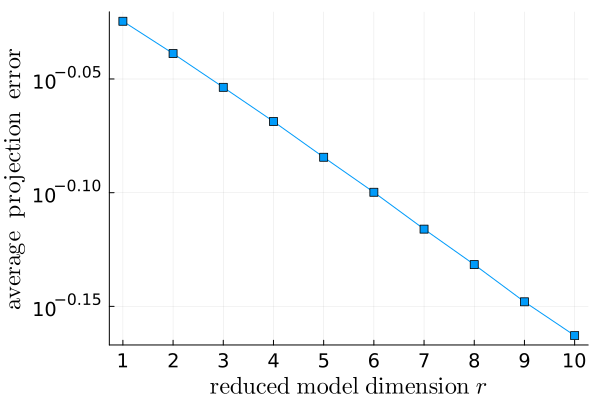

In [10]:
# Training data
mean_train_proj_err = mean(Data["train_proj_err"], dims=2)
plot(rmin:rmax, mean_train_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, legend=false)
# tmp = log10.(mean_train_proj_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{average~~projection~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

### Mean Relative State Error

In [14]:
Data["train_state_err"][:LS]

10×10 Matrix{Float64}:
   0.971408    0.965267    0.960994  …    0.930874    0.925571    0.920799
   2.10047   NaN         NaN              1.06805   NaN         NaN
   4.69438   NaN           1.0397         0.972761    0.966669    0.973963
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN              1.01065     1.25762     0.984227
 NaN         NaN         NaN         …  NaN         NaN         NaN
 NaN         NaN         NaN            NaN           1.0673    NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN

In [13]:
Data["train_state_err"][:int]

10×10 Matrix{Float64}:
   7.06501    0.989005    0.958386  …    0.931359    0.926229    0.92098
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN         …  NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN
 NaN        NaN         NaN            NaN         NaN         NaN

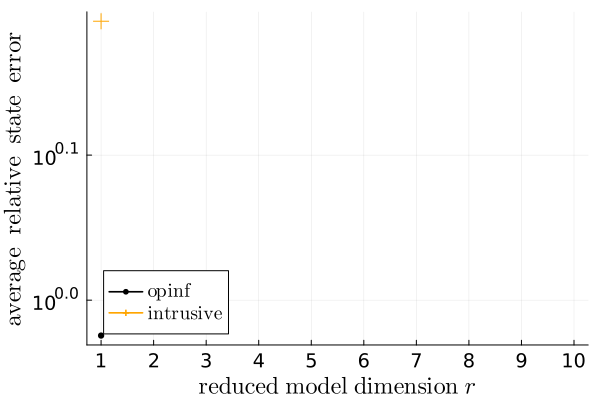

In [11]:
mean_LS_state_err = mean(Data["train_state_err"][:LS], dims=2)
mean_int_state_err = mean(Data["train_state_err"][:int], dims=2)
# mean_ephec_state_err = mean(Data["train_state_err"][:ephec], dims=2)
# mean_epsic_state_err = mean(Data["train_state_err"][:epsic], dims=2)
# mean_epp_state_err = mean(Data["train_state_err"][:epp], dims=2)

plot(rmin:rmax, mean_LS_state_err, c=:black, marker=(:circle, 3.5, :black), label=L"\mathrm{opinf}")
plot!(rmin:rmax, mean_int_state_err, c=:orange, marker=(:cross, 8, :orange), label=L"\mathrm{intrusive}")
# plot!(rmin:rmax, mean_ephec_state_err, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_state_err, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epp_state_err, c=:red, markerstrokecolor=:red, marker=(:star, 4), lw=1, ls=:dash, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
# tmp = log10.(mean_int_state_err)
# yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{average~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)


### Total Energy

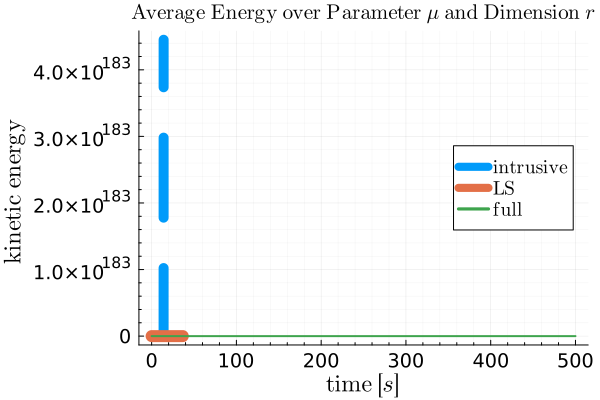

In [16]:
# Training data
mean_LS_En_tr = mean(Data["train_En"][:LS])'
mean_int_En_tr = mean(Data["train_En"][:int])'
# mean_ephec_En_tr = mean(Data["train_En"][:ephec])'
# mean_epsic_En_tr = mean(Data["train_En"][:epsic])'
# mean_epp_En_tr = mean(Data["train_En"][:epp])'
mean_fom_En_tr = mean(Data["train_En"][:fom])

plot(KSE.t, mean_int_En_tr, lw=10, ls=:dash, label=L"\mathrm{intrusive}")
plot!(KSE.t, mean_LS_En_tr, lw=12, ls=:dash, label=L"\mathrm{LS}")
# plot!(KSE.t, mean_ephec_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(KSE.t, mean_epsic_En_tr, lw=4, ls=:dashdotdot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(KSE.t, mean_epp_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(KSE.t, mean_fom_En_tr, lw=2, label=L"\mathrm{full}")
plot!(majorgrid=true, minorgrid=true, legend=:right)
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{kinetic~energy~}")
title!(L"\mathrm{Average~Energy~over~Parameter}~\mu \mathrm{~and~Dimension~} r")
plot!(guidefontsize=16, tickfontsize=13, legendfontsize=13)

### Constraint Residual

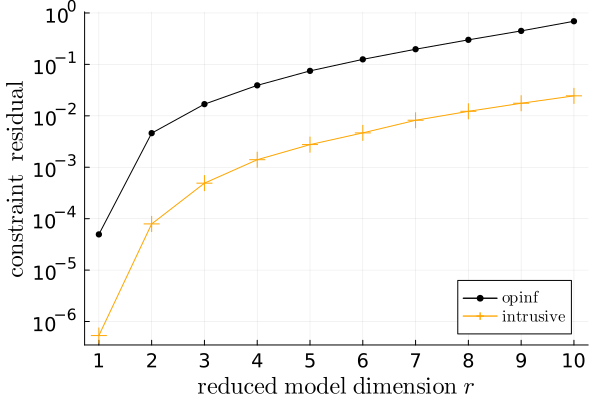

In [20]:
mean_LS_CR_tr = mean(Data["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(Data["train_CR"][:int], dims=2)
# mean_ephec_CR_tr = mean(Data["train_CR"][:ephec], dims=2)
# mean_epsic_CR_tr = mean(Data["train_CR"][:epsic], dims=2)
# mean_epp_CR_tr = mean(Data["train_CR"][:epp], dims=2)
# mean_fom_CR_tr = mean(Data["train_CR"][:fom])

plot(rmin:rmax, mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, mean_int_CR_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
# plot!(rmin:rmax, mean_ephec_CR_tr, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_CR_tr, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epp_CR_tr, c=:red, markerstrokecolor=:red, marker=(:star, 4), ls=:dash, lw=1, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
# yticks!(10.0 .^ [-30, -25, -20, -15, -10, -5, 0])
xticks!(1:15)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=11)

### Momentum

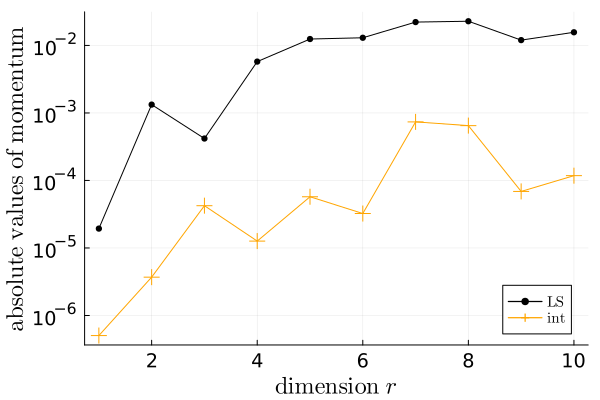

In [19]:
mean_LS_mmt_tr    = abs.(mean(Data["train_mmt"][:LS], dims=2))
mean_int_mmt_tr   = abs.(mean(Data["train_mmt"][:int], dims=2))
# mean_ephec_mmt_tr = abs.(mean(Data["train_mmt"][:ephec], dims=2))
# mean_epsic_mmt_tr = abs.(mean(Data["train_mmt"][:epsic], dims=2))
# mean_epp_mmt_tr = abs.(mean(Data["train_mmt"][:epp], dims=2))
# mean_fom_mmt_tr   = abs.(mean(Data["train_mmt"][:fom]))

plot(rmin:rmax, mean_LS_mmt_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{LS}")
plot!(rmin:rmax, mean_int_mmt_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{int}")
# plot!(rmin:rmax, mean_ephec_mmt_tr, c=:blue, markerstrokecolor=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_mmt_tr, c=:purple, markerstrokecolor=:purple, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epp_mmt_tr, c=:red, markerstrokecolor=:red, marker=(:star, 4), ls=:dash, lw=1, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
# yticks!(10.0 .^ [-30, -24, -18, -12, -6, 0, 6])
xlabel!(L"\mathrm{dimension}~r")
ylabel!(L"\mathrm{absolute~values~of~momentum}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=10)

### Constraint Violation

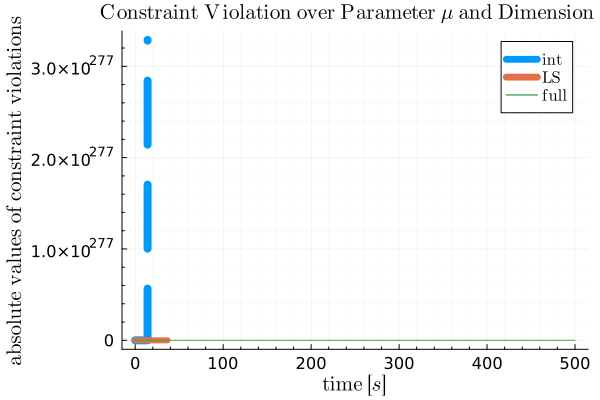

In [22]:
# Training data
mean_LS_CV_tr    = abs.(mean(Data["train_CV"][:LS]))'
mean_int_CV_tr   = abs.(mean(Data["train_CV"][:int]))'
# mean_ephec_CV_tr = abs.(mean(Data["train_CV"][:ephec]))'
# mean_epsic_CV_tr = abs.(mean(Data["train_CV"][:epsic]))'
# mean_epp_CV_tr = abs.(mean(Data["train_CV"][:epp]))'
mean_fom_CV_tr   = abs.(mean(Data["train_CV"][:fom]))

plot(KSE.t, mean_int_CV_tr, lw=8, ls=:dash, label=L"\mathrm{int}")
plot!(KSE.t, mean_LS_CV_tr, lw=6, ls=:dash, label=L"\mathrm{LS}")
# plot!(KSE.t, mean_ephec_CV_tr, lw=3, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(KSE.t, mean_epsic_CV_tr, lw=3, ls=:dashdotdot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(KSE.t, mean_epp_CV_tr, lw=3, ls=:dashdot, label=L"\mathrm{epp}\rm{-}\mathrm{opinf}")
plot!(KSE.t, mean_fom_CV_tr, lw=1, label=L"\mathrm{full}")
plot!(majorgrid=true, minorgrid=true, legend=:topright)
# yticks!(10.0 .^ [-24, -21, -18, -15, -12, -9, -6, -3, 0])
title!(L"\mathrm{Constraint~Violation~over~Parameter}~\mu \mathrm{~and~Dimension~} r")
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{absolute~values~of~constraint~violations}")
plot!(guidefontsize=14, tickfontsize=11,  legendfontsize=11)